Working with Keras

In [1]:
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
#Simple functional model
inputs = keras.Input(shape=(3,), name='my_input')
features = layers.Dense(64, activation='relu')(inputs)
outputs = layers.Dense(10, activation='softmax')(features)
model = keras.Model(inputs=inputs, outputs=outputs)

In [3]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ my_input (InputLayer)           │ (None, 3)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 906 (3.54 KB)

 Trainable params: 906 (3.54 KB)

 Non-trainable params: 0 (0.00 B)

In [4]:
#multi-inputs multi-ouputs models
vocabulary_size = 10000
num_tags = 100
num_departments = 4

title = keras.Input(shape=(vocabulary_size,), name='title')
text_body = keras.Input(shape=(vocabulary_size,), name='text_body')
tags = keras.Input(shape=(num_tags,), name='tags')

features = layers.Concatenate()([title, text_body, tags])
features = layers.Dense(64, activation='relu')(features)

priority = layers.Dense(1, activation='sigmoid', name='priority')(features)
department = layers.Dense(num_departments, activation='softmax', name='department')(features)

mode = keras.Model(inputs=[title, text_body, tags],
                   outputs=[priority, department])

In [5]:
#Simple subclassed model
class CustomerTicketModel(keras.Model):
    def __init__(self, num_departments):
        super().__init__()
        self.concat_layer = layers.Concatenate()
        self.mixing_layer = layers.Dense(64, activation='relu')
        self.priority_scorer = layers.Dense(1, activation='sigmoid')
        self.department_classifier = layers.Dense(num_departments, activation='softmax')

    def call(self, inputs):
        title = inpus('title')
        text_body = inputs['text_body']
        tags = inputs['tags']
        features = self.concat_layer([title, text_body, tags])
        features = self.mixing_layer(features)
        priority = self.priority_scorer(features)
        department = self.department_classifier(features)
        return priority, department

In [6]:
#built-in trainin and evaluation loops
from tensorflow.keras.datasets import mnist
def get_mnist_model():
 inputs = keras.Input(shape=(28 * 28,))
 features = layers.Dense(512, activation="relu")(inputs)
 features = layers.Dropout(0.5)(features)
 outputs = layers.Dense(10, activation="softmax")(features)
 model = keras.Model(inputs, outputs)
 return model
(images, labels), (test_images, test_labels) = mnist.load_data()
images = images.reshape((60000, 28 * 28)).astype("float32") / 255
test_images = test_images.reshape((10000, 28 * 28)).astype("float32") / 255
train_images, val_images = images[10000:], images[:10000]
train_labels, val_labels = labels[10000:], labels[:10000]
model = get_mnist_model()
model.compile(optimizer="rmsprop",
 loss="sparse_categorical_crossentropy",
 metrics=["accuracy"])
model.fit(train_images, train_labels,
 epochs=3,
 validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)
predictions = model.predict(test_images)

Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9107 - loss: 0.2954 - val_accuracy: 0.9563 - val_loss: 0.1493
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9538 - loss: 0.1591 - val_accuracy: 0.9678 - val_loss: 0.1179
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9635 - loss: 0.1289 - val_accuracy: 0.9747 - val_loss: 0.0984
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9751 - loss: 0.0876
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step  


In [7]:
test_metrics

[0.08758697658777237, 0.9750999808311462]

In [8]:
#Implementing a custom metric by subclassing the Metric class
import tensorflow as tf
class RootMeanSquaredError(keras.metrics.Metric):
    def __init__(self, name="rmse", **kwargs):
        super().__init__(name=name, **kwargs)
        self.mse_sum = self.add_weight(name="mse_sum", initializer="zeros")
        self.total_samples = self.add_weight(
            name="total_samples", initializer="zeros", dtype="int32")
    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true = tf.one_hot(y_true, depth=tf.shape(y_pred)[1])
        mse = tf.reduce_sum(tf.square(y_true - y_pred))
        self.mse_sum.assign_add(mse)
        num_samples = tf.shape(y_pred)[0]
        self.total_samples.assign_add(num_samples)
    
    def result(self):
        return tf.sqrt(self.mse_sum/tf.cast(self.total_samples, tf.float32))
    
    def reset_state(self):
        self.mse_sum.assign(0.)
        self.total_samples.assign(0)

In [9]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy", RootMeanSquaredError()])
model.fit(train_images, train_labels,
    epochs=3,  
    validation_data=(val_images, val_labels))
test_metrics = model.evaluate(test_images, test_labels)

Epoch 1/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9120 - loss: 0.2968 - rmse: 0.3634 - val_accuracy: 0.9587 - val_loss: 0.1425 - val_rmse: 0.2497
Epoch 2/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9535 - loss: 0.1587 - rmse: 0.2663 - val_accuracy: 0.9619 - val_loss: 0.1368 - val_rmse: 0.2416
Epoch 3/3
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9632 - loss: 0.1302 - rmse: 0.2387 - val_accuracy: 0.9728 - val_loss: 0.1006 - val_rmse: 0.2040
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - accuracy: 0.9742 - loss: 0.0948 - rmse: 0.2007


In [14]:
callbacks_list = [
    keras.callbacks.EarlyStopping(
       monitor="val_accuracy",
        patience=2,
    ),
 keras.callbacks.ModelCheckpoint(
    filepath="checkpoint_path.keras",
    monitor="val_loss",
    save_best_only=True,
 )
]
model = get_mnist_model()
model.compile(optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])
model.fit(train_images, train_labels,
    epochs=10,
    callbacks=callbacks_list,
    validation_data=(val_images, val_labels)) 

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9122 - loss: 0.2961 - val_accuracy: 0.9549 - val_loss: 0.1531
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9541 - loss: 0.1610 - val_accuracy: 0.9673 - val_loss: 0.1184
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9634 - loss: 0.1278 - val_accuracy: 0.9720 - val_loss: 0.1006
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9679 - loss: 0.1145 - val_accuracy: 0.9738 - val_loss: 0.1009
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9712 - loss: 0.1039 - val_accuracy: 0.9767 - val_loss: 0.0898
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9744 - loss: 0.0950 - val_accuracy: 0.9775 - val_loss: 0.0915
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9761 - loss: 0.0862 - val_accuracy: 0.9788 - val_loss: 0.0877
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9785 - loss: 0.0796 - 

In [15]:
model = keras.models.load_model('checkpoint_path.keras')

In [ ]:
#callbacks used during different stages of the training
on_epoch_begin(epoch, logs) #called at the start of every epoch
on_epoch_end(epoch, logs) #called at the end of every epoch
on_batch_begin(batch, logs) #Called right before processing each batch
on_batch_end(batch, logs) #Called right after proccesing each batch
on_train_begin(logs) #Called ad the start of training
on_train_end(logs) #Called at the end of training


In [20]:
from matplotlib import pyplot as plt
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs):
        self.per_batch_losses = []

    def on_batch_end(self, batch, logs):
        self.per_batch_losses.append(logs.get("loss"))

    def on_epoch_end(self, epoch, logs):
        plt.clf()
        plt.plot(range(len(self.per_batch_losses)), self.per_batch_losses,
        label="Training loss for each batch")
        plt.xlabel(f"Batch (epoch {epoch})")
        plt.ylabel("Loss")
        plt.legend()
        plt.savefig(f"plot_at_epoch_{epoch}")
        self.per_batch_losses = []

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9131 - loss: 0.2958 - val_accuracy: 0.9602 - val_loss: 0.1401
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9537 - loss: 0.1602 - val_accuracy: 0.9669 - val_loss: 0.1197
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9626 - loss: 0.1322 - val_accuracy: 0.9712 - val_loss: 0.1085
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9682 - loss: 0.1135 - val_accuracy: 0.9744 - val_loss: 0.0950
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9718 - loss: 0.1023 - val_accuracy: 0.9754 - val_loss: 0.0943
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9751 - loss: 0.0943 - val_accuracy: 0.9776 - val_loss: 0.0873
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9771 - loss: 0.0883 - val_accuracy: 0.9771 - val_loss: 0.0976
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9773 - loss: 0.0826 - 

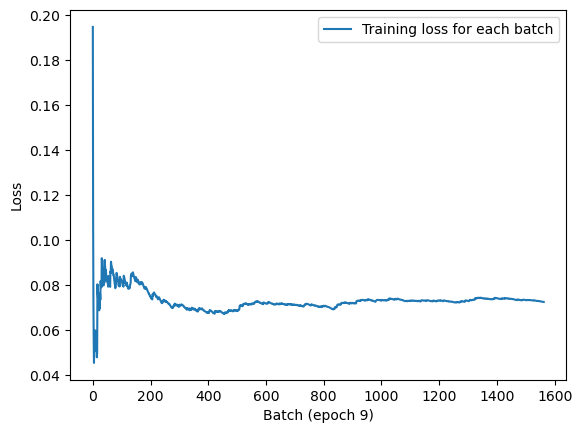

In [21]:
model = get_mnist_model()
model.compile(optimizer="rmsprop",
                loss="sparse_categorical_crossentropy",
                metrics=["accuracy"])
model.fit(train_images, train_labels,
        epochs=10,
        callbacks=[LossHistory()],
        validation_data=(val_images, val_labels))

In [22]:
#Using TensorBoard
model = get_mnist_model()
model.compile(optimizer='rmsprop',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
tensorboard = keras.callbacks.TensorBoard(
    log_dir = '/full_path_to_your_log_dir',
)
model.fit(train_images, train_labels,
          epochs=10,
          validation_data=(val_images, val_labels),
          callbacks=[tensorboard])

Epoch 1/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9116 - loss: 0.2955 - val_accuracy: 0.9562 - val_loss: 0.1506
Epoch 2/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9545 - loss: 0.1590 - val_accuracy: 0.9701 - val_loss: 0.1087
Epoch 3/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - accuracy: 0.9624 - loss: 0.1317 - val_accuracy: 0.9719 - val_loss: 0.1071
Epoch 4/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9682 - loss: 0.1140 - val_accuracy: 0.9737 - val_loss: 0.0971
Epoch 5/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9720 - loss: 0.1038 - val_accuracy: 0.9752 - val_loss: 0.0974
Epoch 6/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9733 - loss: 0.0974 - val_accuracy: 0.9758 - val_loss: 0.0933
Epoch 7/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9762 - loss: 0.0879 - val_accuracy: 0.9784 - val_loss: 0.0876
Epoch 8/10
1563/1563 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - accuracy: 0.9782 - loss: 0.0799 - 

In [24]:
model = get_mnist_model()
loss_fn = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.RMSprop()
metrics = [keras.metrics.SparseCategoricalAccuracy()]
loss_tracking_metric = keras.metrics.Mean()
def train_step(inputs, targets):
    with tf.GradientTape() as tape:
        predictions = model(inputs, training=True)
        loss = loss_fn(targets, predictions)
    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights)) 
    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs[metric.name] = metric.result()
        
    loss_tracking_metric.update_state(loss)
    logs["loss"] = loss_tracking_metric.result()
    return logs

In [25]:
def reset_metrics():
    for metric in metrics:
        metric.reset_state()
    loss_tracking_metric.reset_state()

In [27]:
training_dataset = tf.data.Dataset.from_tensor_slices(
                            (train_images, train_labels))
training_dataset = training_dataset.batch(32)
epochs = 3
for epoch in range(epochs):
    reset_metrics()
    for inputs_batch, targets_batch in training_dataset:
        logs = train_step(inputs_batch, targets_batch)
    print(f"Results at the end of epoch {epoch}")
    for key, value in logs.items():
        print(f"...{key}: {value:.4f}")

Results at the end of epoch 0
...sparse_categorical_accuracy: 0.9146
...loss: 0.2880
Results at the end of epoch 1
...sparse_categorical_accuracy: 0.9545
...loss: 0.1593
Results at the end of epoch 2
...sparse_categorical_accuracy: 0.9639
...loss: 0.1292


In [28]:
def test_step(inputs, targets):
    predictions = model(inputs, training=False)
    loss = loss_fn(targets, predictions)
    logs = {}
    for metric in metrics:
        metric.update_state(targets, predictions)
        logs["val_" + metric.name] = metric.result()
    loss_tracking_metric.update_state(loss)
    logs["val_loss"] = loss_tracking_metric.result()
    return logs

val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels))
val_dataset = val_dataset.batch(32)
reset_metrics()
for inputs_batch, targets_batch in val_dataset:
    logs = test_step(inputs_batch, targets_batch)
print("Evaluation results:")
for key, value in logs.items():
    print(f"...{key}: {value:.4f}")

Evaluation results:
...val_sparse_categorical_accuracy: 0.9676
...val_loss: 0.1226
